# Задание 1

Проведение анализа представленных данных, поиск ключевых характеристик и визуализация.

Вначале импортируем все необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Посмотрим на данные:

In [4]:
train_data = pd.read_excel('train_t.xlsx')

In [5]:
train_data.head()

,id,timestamp,площадь,жилая площадь,этаж,макс этажи,из чего изготовлен,год постройки,число комнат,площадь кухни,...,кол-во больничных коек на райоене,кол-во больниц на районе,число университетов в ТОП 20 университетов москвы,кол-во спортивных объектов на районе,кол-во школ допольнительного обучения на районе,"есть ли культурный объект, входящий ТОП 25 достопримечательностей Москвы","кол-во культурных объектов, входящих в ТОП 25 объектов Москвы",Кол-во торговых центров на районе,Кол-во офисов на районе,цена_продажа
0,1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,...,240.0,1,0,7,3,no,0,16,1,5850000
1,2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,...,229.0,1,0,6,1,yes,1,3,0,6000000
2,3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,...,1183.0,1,0,5,1,no,0,0,1,5700000
3,4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,...,NaN,1,0,17,6,no,0,11,4,13100000
4,5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,...,562.0,4,2,25,2,no,0,10,93,16331452


Начнем анализировать данные. Вначале построим матрицу диаграмм рассеяния количественных признаков:

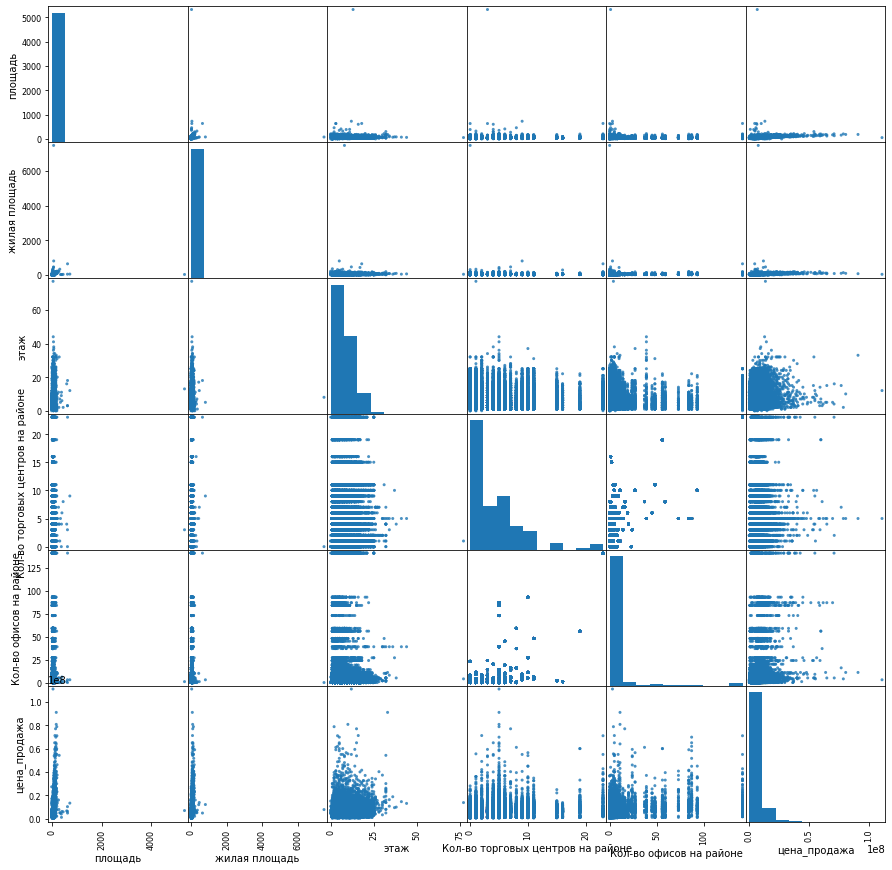

In [6]:
pd.plotting.scatter_matrix(train_data[['площадь', 'жилая площадь', 'этаж', 'Кол-во торговых центров на районе',
                                'Кол-во офисов на районе','цена_продажа']], alpha=0.8, 
                                 figsize=(15, 15), diagonal='hist')
pylab.show()

На основе данной матрицы уже можно уловить некоторые взаимосвязи: например, площадь и жилая площадь, которые фактически обладают линейной взаимосвязью (хотя это и очевидно, но убедиться лишний раз не мешает), поэтому из этих двух переменных при построении прогноза лучше будет оставить только одну, чтобы не допустить мультиколлинеарности. Для этого построим отдельные графики влияния каждого из этих признаков на цену, оставив тот, который влияет больше. Также можно наблюдать что-то похожее на линейную взаимосвязь между количеством торговых центров и количеством офисов на районе, проверим гипотезу о возможной зависимости этих двух признаков.

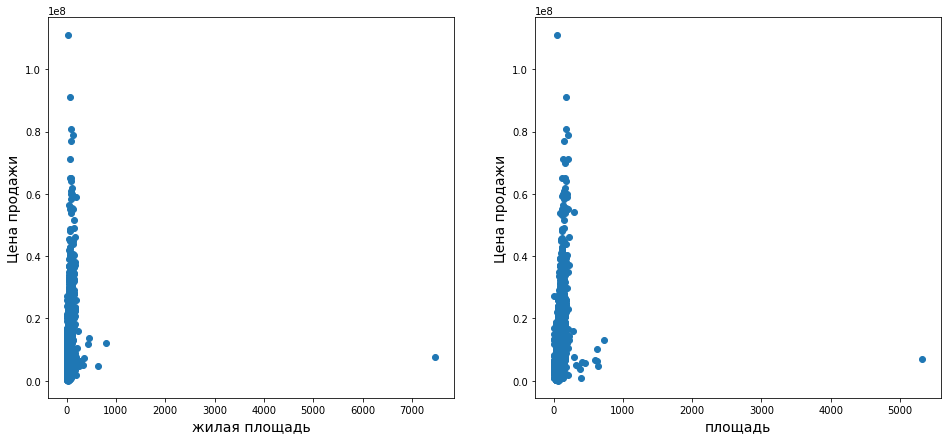

In [7]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(train_data['жилая площадь'], train_data['цена_продажа'])
plt.xlabel('жилая площадь', fontsize=14)
plt.ylabel('Цена продажи', fontsize=14)
plt.subplot(122)
scatter(train_data['площадь'], train_data['цена_продажа'])
plt.xlabel('площадь', fontsize=14)
plt.ylabel('Цена продажи', fontsize=14)
pylab.show()

Одна точка выбивается из одного и из другого графика, уберем их, считая, что это выброс, и посмотрим ещё раз на графики

In [8]:
index1 = train_data[train_data['жилая площадь'] > 3000].index.tolist()
index2 = train_data[train_data['площадь'] > 3000].index.tolist()
index = index1 + index2

In [9]:
train_data.drop(index, inplace=True)

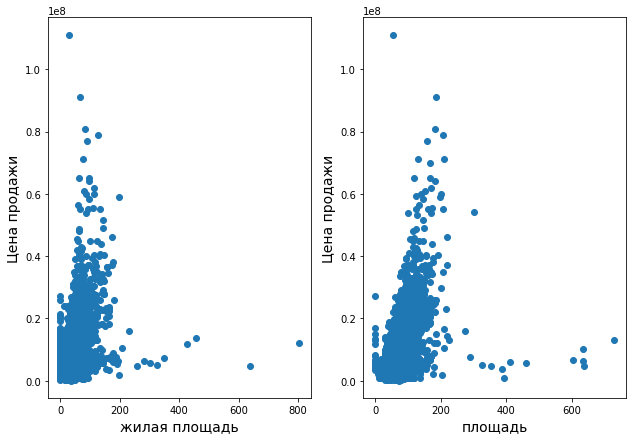

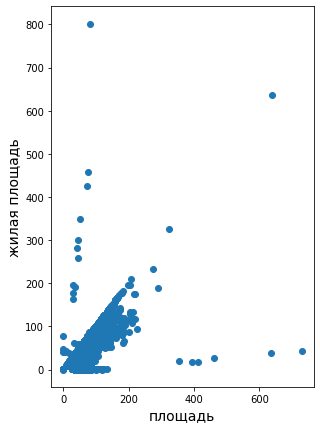

In [10]:
plt.figure(figsize(16,7))
plt.subplot(131)
scatter(train_data['жилая площадь'], train_data['цена_продажа'])
plt.xlabel('жилая площадь', fontsize=14)
plt.ylabel('Цена продажи', fontsize=14)
plt.subplot(132)
scatter(train_data['площадь'], train_data['цена_продажа'])
plt.xlabel('площадь', fontsize=14)
plt.ylabel('Цена продажи', fontsize=14)
pylab.show()
plt.subplot(133)
scatter(train_data['площадь'], train_data['жилая площадь'])
plt.xlabel('площадь', fontsize=14)
plt.ylabel('жилая площадь', fontsize=14)
pylab.show()

На графиках видно, что сохраняется линейная зависимость между признаками. Однако, можно обратить внимание, что на некоторых данных площадь квартиры имеет значение меньше, чем жилая площадь, а такого быть не может, так как жилая площадь входит в общую, эти данные надо брать. 

In [11]:
index = train_data[train_data['жилая площадь'] > train_data['площадь']].index.tolist()
train_data.drop(index, inplace=True)

Так как, несмотря на линейную взаимосвязь, важно сохранить информацию как о площадь, так и о жилой площади, попробуем понизить размрность данных, преобразовав эти два признака в один с помощью метода главных компонент. Обратим внимание, что в некоторых строках в столбце "жилая площадь" имеются пропуски (причем более, чем в 5000 случаях):

In [12]:
sum(train_data['жилая площадь'].isnull())

5124

Удалим их

In [13]:
index = train_data[train_data['жилая площадь'].isnull()].index.tolist()
train_data.drop(index, inplace=True)

Предварительно обработаем пропуски в столбце "число комнат". Для тех, у кого будет совпадать жилая площадь или общая, будем заполнять ячейки таким же количеством комнат, остальные (если таковые останусться) - заменим медианным значением.

In [14]:
tmp_data1 = train_data.groupby(['жилая площадь']).median()
for now1 in tmp_data1.index:
    for now2 in train_data.index:
        if train_data.loc[now2, 'жилая площадь'] == now1 and math.isnan(train_data.loc[now2, 'число комнат']):
            train_data.loc[now2, 'число комнат'] = tmp_data1.loc[now1, 'число комнат']
            
tmp_data2 = train_data.groupby(['жилая площадь']).median()
for now1 in tmp_data2.index:
    for now2 in train_data.index:
        if train_data.loc[now2, 'жилая площадь'] == now1 and math.isnan(train_data.loc[now2, 'число комнат']):
            train_data.loc[now2, 'число комнат'] = tmp_data2.loc[now1, 'число комнат']

train_data.dropna(axis='index', how='any', subset=['число комнат'], inplace=True)

In [15]:
X = np.vstack((np.array(train_data['площадь']), np.array(train_data['жилая площадь'])))

In [16]:
pca_1 = PCA(n_components=1)
pca_train = pca_1.fit_transform(X.T)

Посмотрим сколько информации от исходных данных несёт новая главная компонента

In [17]:
pca_1.explained_variance_ratio_

array([0.88296764])

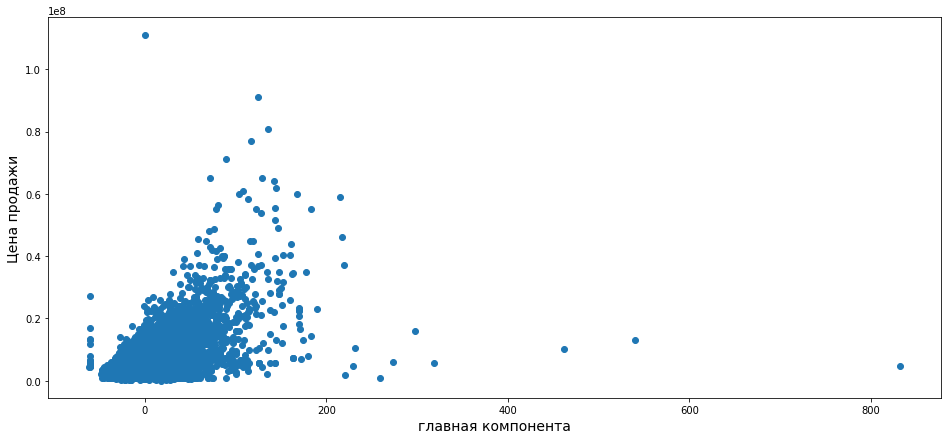

In [18]:
scatter(pca_train, train_data['цена_продажа'])
plt.xlabel('главная компонента', fontsize=14)
plt.ylabel('Цена продажи', fontsize=14)
pylab.show()

Заменим столбцы "площадь" и "жилая площадь" на новый получившийся

In [19]:
train_data['площадь'] = pca_train

In [20]:
train_data.rename(columns={'площадь': 'главная компонента площади'}, inplace=True)
train_data.drop(['жилая площадь'], axis='columns', inplace=True)
train_data.drop(['площадь кухни'], axis='columns', inplace=True)

In [21]:
train_data.head()

,id,timestamp,главная компонента площади,этаж,макс этажи,из чего изготовлен,год постройки,число комнат,состояние жилья,тип жилья,...,кол-во больничных коек на райоене,кол-во больниц на районе,число университетов в ТОП 20 университетов москвы,кол-во спортивных объектов на районе,кол-во школ допольнительного обучения на районе,"есть ли культурный объект, входящий ТОП 25 достопримечательностей Москвы","кол-во культурных объектов, входящих в ТОП 25 объектов Москвы",Кол-во торговых центров на районе,Кол-во офисов на районе,цена_продажа
0,1,2011-08-20,-11.195782,4.0,NaN,NaN,NaN,2.0,NaN,Investment,...,240.0,1,0,7,3,no,0,16,1,5850000
1,2,2011-08-23,-23.212333,3.0,NaN,NaN,NaN,1.0,NaN,Investment,...,229.0,1,0,6,1,yes,1,3,0,6000000
2,3,2011-08-27,-9.966175,2.0,NaN,NaN,NaN,2.0,NaN,Investment,...,1183.0,1,0,5,1,no,0,0,1,5700000
3,4,2011-09-01,39.223992,9.0,NaN,NaN,NaN,3.0,NaN,Investment,...,NaN,1,0,17,6,no,0,11,4,13100000
4,5,2011-09-05,46.359526,4.0,NaN,NaN,NaN,3.0,NaN,Investment,...,562.0,4,2,25,2,no,0,10,93,16331452


Построим диаграмму рассеяния столбцов "Кол-во торговых центров на районе" и "Кол-во офисов на районе":

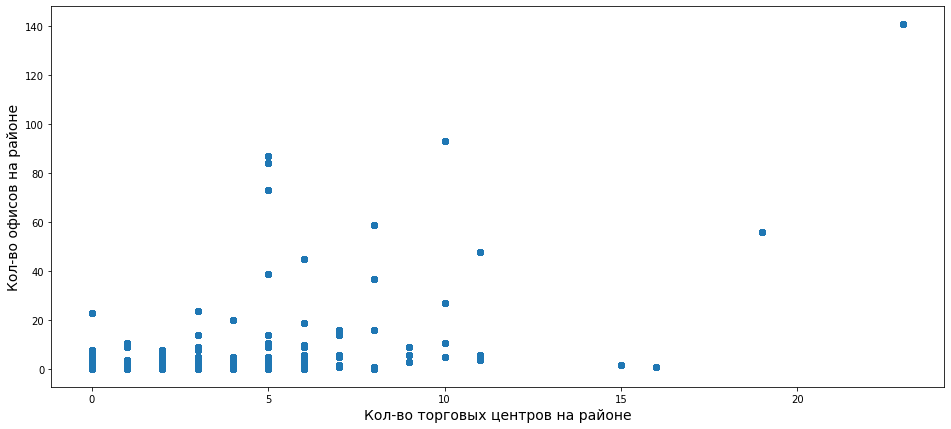

In [22]:
scatter(train_data['Кол-во торговых центров на районе'], train_data['Кол-во офисов на районе'])
plt.xlabel('Кол-во торговых центров на районе', fontsize=14)
plt.ylabel('Кол-во офисов на районе', fontsize=14)
pylab.show()

Глядя на график нельзя отбросить вариант с тем, что имеется зависимость. Проверим гипотезу о наличии линейной взаимосвязи с помощью критерия Стьюдента:

In [23]:
train_data[['Кол-во торговых центров на районе', 'Кол-во офисов на районе']].corr()

,Кол-во торговых центров на районе,Кол-во офисов на районе
Кол-во торговых центров на районе,1.000000,0.523702
Кол-во офисов на районе,0.523702,1.000000


In [24]:
stat, p = pearsonr(train_data['Кол-во офисов на районе'], train_data['Кол-во торговых центров на районе'])
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.524, p=0.000
Probably dependent


Достигаемый уровень значимости много меньше 0.05, следовательно, отвергаем критерий о независимости двух величин. Попробуем из них также с помошью метода главных компонент сделать одну:

In [25]:
X = np.vstack((np.array(train_data['Кол-во офисов на районе']), np.array(train_data['Кол-во торговых центров на районе'])))

In [26]:
pca2 = PCA(n_components=1)
pca_train2 = pca2.fit_transform(X.T)

In [27]:
train_data['Кол-во офисов на районе'] = pca_train2

In [28]:
train_data.rename(columns={'Кол-во офисов на районе': 'главная компонента тц и офисов'}, inplace=True)
train_data.drop(['Кол-во торговых центров на районе'], axis='columns', inplace=True)

Теперь поработаем с категориальными признаками, а именно с районом. Район будем кодировать средней ценой (по данному району). 

In [29]:
area = train_data.groupby(['район']).mean()

In [30]:
# функция возвращает значения нового признака
def code_mean(data, cat_feature, real_feature):
    return (data[cat_feature].map(data.groupby(cat_feature)[real_feature].mean()))

train_data['средняя_цена_по_району'] = code_mean(train_data, 'район', 'цена_продажа')

Обрати внимание, что в двух соседних колонках "есть ли культурный объект, входящий ТОП 25 достопримечательностей Москвы" и "кол-во культурных объектов, входящих в ТОП 25 объектов Москвы" отображена одна и та же информация, но в правой она представлена ещё и численно, что, безусловно, удобнее для алгоритмов машинного обучения. Поэтому "есть ли культурный объект, входящий ТОП 25 достопримечательностей Москвы" можно удалить.

In [31]:
train_data.drop(['есть ли культурный объект, входящий ТОП 25 достопримечательностей Москвы'], axis='columns', inplace=True)

В столбце "из чего изготовлен" есть очень много пропусков, однако это очень важный показатель для расчета стоимость квартиры, поэтому заменим все неизвестные значения на 0 (считаем как отдельную категория):

In [32]:
train_data['из чего изготовлен'].fillna(0, inplace=True)

Теперь посмотрим на количество различных значений, который принимает столбец "тип жилья":

In [33]:
train_data['тип жилья'].value_counts()

Investment       16277
OwnerOccupier     3533
Name: тип жилья, dtype: int64

Только два значения. Тогда можно сделать данный признак бинарным: 

- Investment - "1"

- OwnerOccupier - "0" 

In [34]:
train_data['тип жилья'] = train_data['тип жилья'].map({'Investment': 1, 'OwnerOccupier': 0}) 

Посмотрим на значения столбца "состояние жилья":

In [35]:
train_data['состояние жилья'].value_counts()

2.0     4377
3.0     4352
1.0     2068
4.0      334
33.0       1
Name: состояние жилья, dtype: int64

In [36]:
sum(train_data['состояние жилья'].isna())

8678

Видно, что много данных пропущено, к тому же есть выброс, у которого значение состояния жилья равно 33.0. Удалим этот выброс из таблицы, а на месте пропусков попробуем поставить медианное значение состояния жилья, присущее конкретному району.

In [37]:
outlier = train_data[train_data['состояние жилья'] == 33].index
train_data.drop(outlier, axis='index', inplace=True)
tmp_data = train_data.groupby(['средняя_цена_по_району']).median()

In [38]:
for now1 in tmp_data.index:
    for now2 in train_data.index:
        if train_data.loc[now2, 'средняя_цена_по_району'] == now1 and math.isnan(train_data.loc[now2, 'состояние жилья']):
            train_data.loc[now2, 'состояние жилья'] = tmp_data.loc[now1, 'состояние жилья']

In [39]:
sum(train_data['состояние жилья'].isna())

1

Все ещё остались незаполненные значения, тогда просто заменим их общими медианами:

In [40]:
train_data['состояние жилья'].fillna(train_data['состояние жилья'].median(), inplace=True)
train_data['состояние жилья'] = np.floor(train_data['состояние жилья'])

Посмотрим как влияет год постройки:

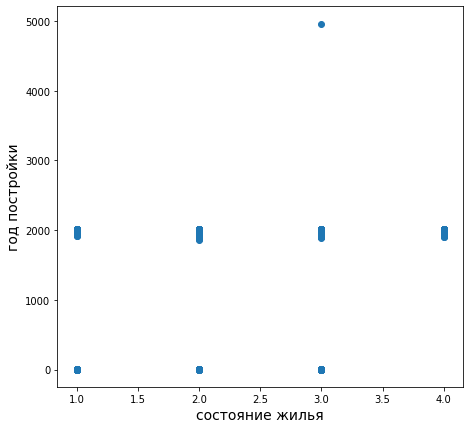

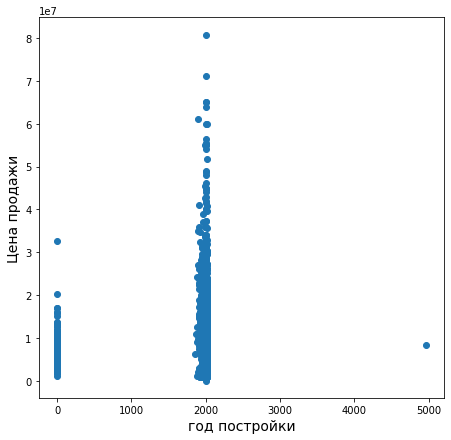

In [41]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(train_data['состояние жилья'], train_data['год постройки'])
plt.xlabel('состояние жилья', fontsize=14)
plt.ylabel('год постройки', fontsize=14)
pylab.show()
plt.subplot(122)
scatter(train_data['год постройки'], train_data['цена_продажа'])
plt.xlabel('год постройки', fontsize=14)
plt.ylabel('Цена продажи', fontsize=14)
pylab.show()

Так как учли состояние, то год постройки можно не учитывать (к тому же в нем достаточно много пропусков, а те данные), однако, прежде чем удалять весь столбец, удалим строку с выбросом, соответствующей 5000 году:

In [42]:
outlier = train_data[train_data['год постройки'] > 2020].index
train_data.drop(outlier, inplace=True)
train_data.drop(['год постройки'], axis='columns', inplace=True)

Важными показателями в таблице являются также количество школ и детских садов, но не их абсолютное количество, а относительная величина - количество школьников/дошкольников на одну школу или один десткий сад. Преобразуем четыре этих столбца в два:

In [43]:
train_data['количество дошкольников на 1 дет сад'] = train_data['кол-во дошкольников'] / train_data['вместимость дет.садов']
train_data['количество школьников на 1 школу'] = train_data['кол-во школьников'] / train_data['вместимость школ']
train_data.drop(['кол-во дошкольников'], axis='columns', inplace=True)
train_data.drop(['кол-во школьников'], axis='columns', inplace=True)
train_data.drop(['вместимость дет.садов'], axis='columns', inplace=True)
train_data.drop(['вместимость школ'], axis='columns', inplace=True)
train_data.drop(['кол-во дет.садов на районе'], axis='columns', inplace=True)
train_data.drop(['кол-во школ на районе'], axis='columns', inplace=True)

Проверим, не осталось ли пропусков в данных:

In [44]:
print(sum(train_data['количество дошкольников на 1 дет сад'].isna()))
print(sum(train_data['количество школьников на 1 школу'].isna()))

2373
2371


Устраним их, заменяя средним значением по одинаковым районам, и, если после этого остануться пропуски, просто удалим их:

In [45]:
tmp_data = train_data.groupby(['район']).median()

for now1 in tmp_data.index:
    for now2 in train_data.index:
        if train_data.loc[now2, 'район'] == now1 and math.isnan(train_data.loc[now2, 'количество дошкольников на 1 дет сад']):
            train_data.loc[now2, 'количество дошкольников на 1 дет сад'] = tmp_data.loc[now1, 'количество дошкольников на 1 дет сад']

for now1 in tmp_data.index:
    for now2 in train_data.index:
        if train_data.loc[now2, 'район'] == now1 and math.isnan(train_data.loc[now2, 'количество школьников на 1 школу']):
            train_data.loc[now2, 'количество школьников на 1 школу'] = tmp_data.loc[now1, 'количество школьников на 1 школу']

In [46]:
train_data.dropna(axis='index', how='any', subset=['количество дошкольников на 1 дет сад'], inplace=True)
train_data.dropna(axis='index', how='any', subset=['количество школьников на 1 школу'], inplace=True)
train_data.drop(['район'], axis='columns', inplace=True)

Посмотрим как влияют на цену число больничных коек и число больниц:

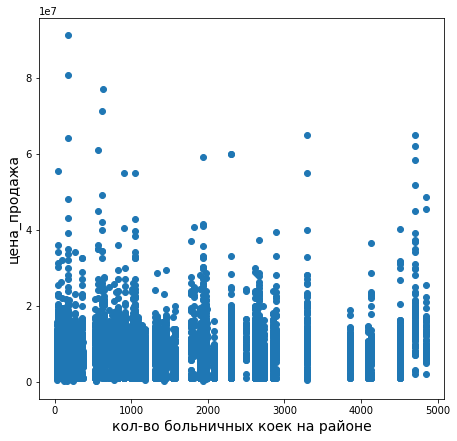

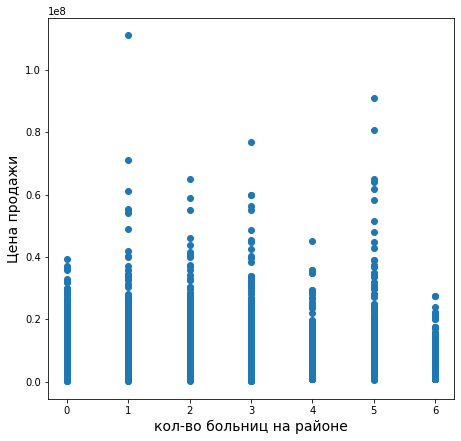

In [47]:
plt.figure(figsize(16,7))
plt.subplot(121)
scatter(train_data['кол-во больничных коек на райоене'], train_data['цена_продажа'])
plt.xlabel('кол-во больничных коек на районе', fontsize=14)
plt.ylabel('цена_продажа', fontsize=14)
pylab.show()
plt.subplot(122)
scatter(train_data['кол-во больниц на районе'], train_data['цена_продажа'])
plt.xlabel('кол-во больниц на районе', fontsize=14)
plt.ylabel('Цена продажи', fontsize=14)
pylab.show()

Количество больничных коек на районе не влияют заметно на цену жилья, от этого столбца можно избавиться. Количество больниц имеет зависимость, похожую на линейную, одна точка правда выбивается довольно сильно из общей тенденции, проверим, является ли она выбросом с помощью интерквартильного размаха.

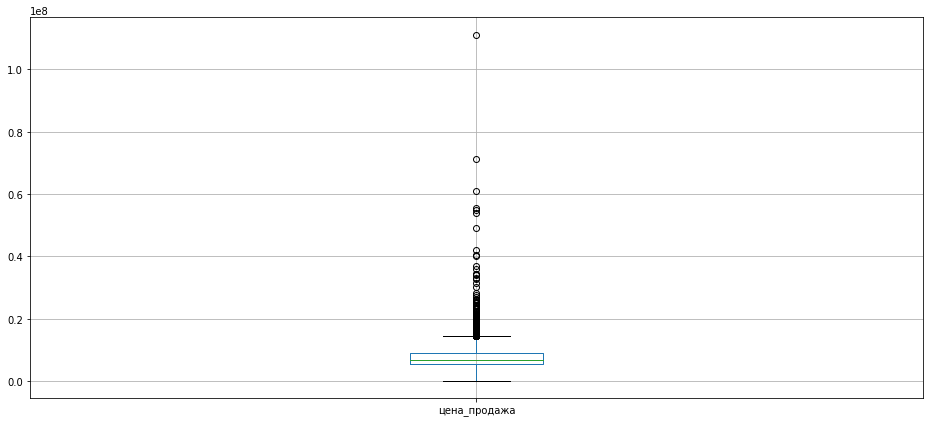

In [48]:
data = train_data[train_data['кол-во больниц на районе']== 1]
data.boxplot(column=['цена_продажа'])

Точка и тут очень сильно выбивается, уберем её.

In [49]:
outlier = train_data[train_data['цена_продажа'] > 1e8].index
train_data.drop(['кол-во больничных коек на райоене'], axis='columns', inplace=True)
train_data.drop(outlier, inplace=True)

In [50]:
train_data.head()

,id,timestamp,главная компонента площади,этаж,макс этажи,из чего изготовлен,число комнат,состояние жилья,тип жилья,площадь района,...,кол-во больниц на районе,число университетов в ТОП 20 университетов москвы,кол-во спортивных объектов на районе,кол-во школ допольнительного обучения на районе,"кол-во культурных объектов, входящих в ТОП 25 объектов Москвы",главная компонента тц и офисов,цена_продажа,средняя_цена_по_району,количество дошкольников на 1 дет сад,количество школьников на 1 школу
0,1,2011-08-20,-11.195782,4.0,NaN,0.0,2.0,3.0,1,6.407578e+06,...,1,0,7,3,0,-5.521740,5850000,6.624409e+06,1.914817,0.931676
1,2,2011-08-23,-23.212333,3.0,NaN,0.0,1.0,2.0,1,9.589337e+06,...,1,0,6,1,1,-8.033265,6000000,7.658988e+06,2.205835,1.244028
2,3,2011-08-27,-9.966175,2.0,NaN,0.0,2.0,2.0,1,4.808270e+06,...,1,0,5,1,0,-7.390502,5700000,6.541743e+06,4.018455,1.112366
3,4,2011-09-01,39.223992,9.0,NaN,0.0,3.0,2.0,1,1.258354e+07,...,1,0,17,6,0,-3.126261,13100000,8.818039e+06,1.913584,0.801149
4,5,2011-09-05,46.359526,4.0,NaN,0.0,3.0,2.0,1,8.398461e+06,...,4,2,25,2,0,85.147802,16331452,1.166152e+07,1.761111,0.868468


В столбцах "этаж" и "максимальный этаж" есть пропуски в данных. В столбце этаж пропущено всего 83 пункта - удалим их, в столбце максимальный этаж заменим максимальное значение этажа значением этажа, на котором находиться продаваемое помещение.

In [51]:
print(sum(train_data['этаж'].isna()))
print(sum(train_data['макс этажи'].isna()))

83
6317


In [52]:
for now in train_data.index:
    if math.isnan(train_data.loc[now, 'макс этажи']):
        train_data.loc[now, 'макс этажи'] = train_data.loc[now, 'этаж']

In [53]:
train_data.dropna(axis='index', how='any', subset=['этаж'], inplace=True)

Сгенерируем признаки месяц и год:

In [54]:
train_data.timestamp = train_data.timestamp.apply(pd.to_datetime)
train_data['month'] = train_data.timestamp.apply(lambda x : x.month)
train_data['year'] = train_data.timestamp.apply(lambda x : x.year)

In [55]:
train_data.drop(['timestamp'], axis='columns', inplace=True)
train_data.drop(['id'], axis='columns', inplace=True)

In [56]:
train_data.rename(columns={'чисо жителей': 'число жителей'}, inplace=True)

In [57]:
train_data =  train_data.reindex(['month','year', 'главная компонента площади','этаж','макс этажи',
                                  'из чего изготовлен','число комнат',
                                  'состояние жилья','тип жилья','площадь района','число жителей','площадь зеленой зоны',
                                  'площадь индустриальной зоны', 'число школ в рейтинге ТОП 20 школ москвы','кол-во больниц на районе',
                                  'число университетов в ТОП 20 университетов москвы', 'кол-во спортивных объектов на районе',
                                  'кол-во школ допольнительного обучения на районе','кол-во культурных объектов, входящих в ТОП 25 объектов Москвы',
                                  'главная компонента тц и офисов','цена_продажа','средняя_цена_по_району',
                                  'количество дошкольников на 1 дет сад', 'количество школьников на 1 школу'], axis='columns')

In [58]:
train_data.head()

,month,year,главная компонента площади,этаж,макс этажи,из чего изготовлен,число комнат,состояние жилья,тип жилья,площадь района,...,кол-во больниц на районе,число университетов в ТОП 20 университетов москвы,кол-во спортивных объектов на районе,кол-во школ допольнительного обучения на районе,"кол-во культурных объектов, входящих в ТОП 25 объектов Москвы",главная компонента тц и офисов,цена_продажа,средняя_цена_по_району,количество дошкольников на 1 дет сад,количество школьников на 1 школу
0,8,2011,-11.195782,4.0,4.0,0.0,2.0,3.0,1,6.407578e+06,...,1,0,7,3,0,-5.521740,5850000,6.624409e+06,1.914817,0.931676
1,8,2011,-23.212333,3.0,3.0,0.0,1.0,2.0,1,9.589337e+06,...,1,0,6,1,1,-8.033265,6000000,7.658988e+06,2.205835,1.244028
2,8,2011,-9.966175,2.0,2.0,0.0,2.0,2.0,1,4.808270e+06,...,1,0,5,1,0,-7.390502,5700000,6.541743e+06,4.018455,1.112366
3,9,2011,39.223992,9.0,9.0,0.0,3.0,2.0,1,1.258354e+07,...,1,0,17,6,0,-3.126261,13100000,8.818039e+06,1.913584,0.801149
4,9,2011,46.359526,4.0,4.0,0.0,3.0,2.0,1,8.398461e+06,...,4,2,25,2,0,85.147802,16331452,1.166152e+07,1.761111,0.868468


Проверим нет осталось ли пропусков в данных:

In [59]:
sum(train_data.isna())

month                                                            0
year                                                             0
главная компонента площади                                       0
этаж                                                             0
макс этажи                                                       0
из чего изготовлен                                               0
число комнат                                                     0
состояние жилья                                                  0
тип жилья                                                        0
площадь района                                                   0
число жителей                                                    0
площадь зеленой зоны                                             0
площадь индустриальной зоны                                      0
число школ в рейтинге ТОП 20 школ москвы                         0
кол-во больниц на районе                                      

In [60]:
train_data.to_csv('C:/Users/Артем/Interviews/UD Group/train_data.csv',encoding='utf-8', index=False)

Данные предобработаны, теперь переходим ко второму заданию - построение модели:

# Задача 2

Построить модель предсказания цены продажи каждого лота жилой недвижимости (переменная «цена_продажа» в выборке train).

In [61]:
train_data = pd.read_csv('train_data.csv')

In [62]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

train = clean_dataset(train_data)

In [63]:
targets = train['цена_продажа']
train.drop(['цена_продажа'], axis='columns', inplace=True)

Сначала отнормируем такие данные как "главная компонента площади", "площадь района", "число жителей", "площадь зеленой зоны", "площадь индустриальной зоны".                                                                                                

In [64]:
scaler_square_flat = MinMaxScaler()
x1 = train_data[['главная компонента площади']].values.astype(float)
train_data[['главная компонента площади']] = scaler_square_flat.fit_transform(x1)

scaler_square_area = MinMaxScaler()
x2 = train_data[['площадь района']].values.astype(float)
train_data[['площадь района']] = scaler_square_area.fit_transform(x2)

scaler_square_green = MinMaxScaler()
x3 = train_data[['площадь зеленой зоны']].values.astype(float)
train_data[['площадь зеленой зоны']] = scaler_square_green.fit_transform(x3)

scaler_square_people = MinMaxScaler()
x4 = train_data[['число жителей']].values.astype(float)
train_data[['число жителей']] = scaler_square_people.fit_transform(x4)

scaler_square_industry = MinMaxScaler()
x5 = train_data[['площадь индустриальной зоны']].values.astype(float)
train_data[['площадь индустриальной зоны']] = scaler_square_industry.fit_transform(x5)

scaler_square_office = MinMaxScaler()
x6 = train_data[['главная компонента тц и офисов']].values.astype(float)
train_data[['главная компонента тц и офисов']] = scaler_square_office.fit_transform(x6)

scaler_square_office = MinMaxScaler()
x7 = train_data[['средняя_цена_по_району']].values.astype(float)
train_data[['средняя_цена_по_району']] = scaler_square_office.fit_transform(x7)

Данные готовы. Пробуем настроить предсказатели. Чаще всего используеют в данных задачах следующие модели:

- «Случайный лес».

- Градиентный бустинг.

- Метод опорных векторов.

Обучим их. Но сперва подготовим тестовую выборку, по которой мы будем проверять качество модели. Разобьем данные на обучение и валидацию (отложенный тест):

In [65]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.33)

In [66]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.replace([np.inf, -np.inf], np.nan).dropna(how="all", axis=1, inplace=True)

Обучение проводилось на платформе GoogleColab(нумерация строк оттуда)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

loss = ['ls', 'lad', 'huber']
n_estimators = [100, 500, 1000]
max_depth = [5, 10]
min_samples_leaf = [1, 2, 6]
min_samples_split = [2, 4, 6]

max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'loss': loss,
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

GB_model = GradientBoostingRegressor(random_state = 42)

random_cv = RandomizedSearchCV(estimator=GB_model,
    param_distributions=hyperparameter_grid,
    cv=4, n_iter=25, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 1, 
    return_train_score = True,
    random_state=42)

random_cv.fit(X_train, y_train)

print(random_cv.best_estimator_)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 17.8min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 29.8min finished


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [25]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = [1000, 1200, 1500]
max_depth = [5, 10, 15, 20]
min_samples_leaf = [1, 2, 6, 8]
min_samples_split = [2, 4, 6, 10]

max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'max_features': max_features}

random_forest = RandomForestRegressor(random_state=42)

random_cv = RandomizedSearchCV(estimator=random_forest,
    param_distributions=hyperparameter_grid,
    cv=4, n_iter=25, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 1, 
    return_train_score = True,
    random_state=42)

random_cv.fit(X_train, y_train)

print(random_cv.best_estimator_)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 42.5min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


In [28]:
from sklearn.svm import SVR

kernel = ['poly', 'rbf', 'sigmoid']
C = [500.0, 1000.0, 1200.0]

hyperparameter_grid = {'kernel': kernel,
    'C': C}

SVM = SVR()

random_cv = RandomizedSearchCV(estimator=SVM,
    param_distributions=hyperparameter_grid,
    cv=4, n_iter=25, 
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1, verbose = 1, 
    return_train_score = True,
    random_state=42)

random_cv.fit(X_train, y_train)

print(random_cv.best_estimator_)

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.9min finished


SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


Протестируем лучшие классификаторы и сравним, какие из них лучше отработают на отложенном тесте:

In [67]:
# Create the model Gradient Boosting
gradient_boosted = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='lad', max_depth=5,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=6,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
gradient_boosted.fit(X_train, y_train)


predictions = gradient_boosted.predict(X_test)
mae = np.mean(abs(predictions - y_test))

print('Gradient Boosted Performance on the test set: MAE = %0.4f' % mae)

Gradient Boosted Performance on the test set: MAE = 1663284.1275


In [68]:
# Create the model Random Forest
random_forest = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='log2', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

random_forest.fit(X_train, y_train)


predictions = random_forest.predict(X_test)
mae = np.mean(abs(predictions - y_test))

print('Random Forest Performance on the test set: MAE = %0.4f' % mae)

Random Forest Performance on the test set: MAE = 1845136.9598


In [69]:
# Create the model SVM

svm = SVR(C=1000.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

svm.fit(X_train, y_train)


predictions = svm.predict(X_test)
mae = np.mean(abs(predictions - y_test))

print('Support Vector Machine on the test set: MAE = %0.4f' % mae)

Support Vector Machine on the test set: MAE = 2873459.9877


Наименьшую ошибку показал GradientBoosting - его и будем использовать в качестве основного алгоритма для предсказания. Но сначала предобработаем тестовые данные:

In [70]:
test_data = pd.read_excel('test_t.xlsx')

In [71]:
for (now1, i) in zip(test_data['район'], range(len(test_data['район']))):
    for now2 in area.index:
        if now1 == now2:
            test_data.loc[i, 'район'] = area.loc[now2, 'цена_продажа']
test_data.rename(columns={'район': 'средняя_цена_по_району'}, inplace=True)

In [72]:
test_data.dropna(axis=0, inplace=True)

index = test_data[test_data['жилая площадь'] > test_data['площадь']].index.tolist()
test_data.drop(index, inplace=True)
X1 = np.vstack((np.array(test_data['площадь']), np.array(test_data['жилая площадь'])))
pca_test_1 = pca_1.transform(X1.T)

test_data['площадь'] = pca_test_1

test_data['количество дошкольников на 1 дет сад'] = test_data['кол-во дошкольников'] / test_data['вместимость дет.садов']
test_data['количество школьников на 1 школу'] = test_data['кол-во школьников'] / test_data['вместимость школ']

X2 = np.vstack((np.array(test_data['Кол-во офисов на районе']), np.array(test_data['Кол-во торговых центров на районе'])))
pca_test_2 = pca2.transform(X2.T)
test_data['Кол-во офисов на районе'] = pca_test_2

test_data['тип жилья'] = test_data['тип жилья'].map({'Investment': 1, 'OwnerOccupier': 0}) 


test_data.drop(['есть ли культурный объект, входящий ТОП 25 достопримечательностей Москвы'], axis='columns', inplace=True)
test_data.rename(columns={'площадь': 'главная компонента площади'}, inplace=True)
test_data.drop(['жилая площадь'], axis='columns', inplace=True)

test_data.rename(columns={'Кол-во офисов на районе': 'главная компонента тц и офисов'}, inplace=True)
test_data.drop(['Кол-во торговых центров на районе'], axis='columns', inplace=True)

test_data.drop(['площадь кухни'], axis='columns', inplace=True)
test_data.drop(['кол-во дошкольников'], axis='columns', inplace=True)
test_data.drop(['кол-во школьников'], axis='columns', inplace=True)
test_data.drop(['вместимость дет.садов'], axis='columns', inplace=True)
test_data.drop(['вместимость школ'], axis='columns', inplace=True)
test_data.drop(['кол-во дет.садов на районе'], axis='columns', inplace=True)
test_data.drop(['кол-во школ на районе'], axis='columns', inplace=True)
test_data.drop(['кол-во больничных коек на райоене'], axis='columns', inplace=True)
test_data.drop(['год постройки'], axis='columns', inplace=True)
test_data.drop(['id'], axis='columns', inplace=True)
test_data.rename(columns={'чисо жителей': 'число жителей'}, inplace=True)

In [73]:
test_data.timestamp = test_data.timestamp.apply(pd.to_datetime)
test_data['month'] = test_data.timestamp.apply(lambda x : x.month)
test_data['year'] = test_data.timestamp.apply(lambda x : x.year)
test_data.drop(['timestamp'], axis='columns', inplace=True)

In [74]:
test_data =  test_data.reindex(['month','year', 'главная компонента площади','этаж','макс этажи',
                                  'из чего изготовлен','число комнат',
                                  'состояние жилья','тип жилья','площадь района','число жителей','площадь зеленой зоны',
                                  'площадь индустриальной зоны', 'число школ в рейтинге ТОП 20 школ москвы','кол-во больниц на районе',
                                  'число университетов в ТОП 20 университетов москвы', 'кол-во спортивных объектов на районе',
                                  'кол-во школ допольнительного обучения на районе','кол-во культурных объектов, входящих в ТОП 25 объектов Москвы',
                                  'главная компонента тц и офисов','средняя_цена_по_району',
                                  'количество дошкольников на 1 дет сад', 'количество школьников на 1 школу'], axis='columns')

In [75]:
x1 = test_data[['главная компонента площади']].values.astype(float)
test_data[['главная компонента площади']] = scaler_square_flat.fit_transform(x1)

x2 = test_data[['площадь района']].values.astype(float)
test_data[['площадь района']] = scaler_square_area.fit_transform(x2)

x3 = test_data[['площадь зеленой зоны']].values.astype(float)
test_data[['площадь зеленой зоны']] = scaler_square_green.fit_transform(x3)

x4 = test_data[['число жителей']].values.astype(float)
test_data[['число жителей']] = scaler_square_people.fit_transform(x4)

x5 = test_data[['площадь индустриальной зоны']].values.astype(float)
test_data[['площадь индустриальной зоны']] = scaler_square_industry.fit_transform(x5)

x6 = test_data[['главная компонента тц и офисов']].values.astype(float)
test_data[['главная компонента тц и офисов']] = scaler_square_office.fit_transform(x6)

x7 = test_data[['средняя_цена_по_району']].values.astype(float)
test_data[['средняя_цена_по_району']] = scaler_square_office.fit_transform(x7)

Делаем итоговое предсказание:

In [76]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(axis=0, inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

test = clean_dataset(test_data)
predictions_test = gradient_boosted.predict(test)

In [77]:
pd.DataFrame(predictions_test).to_csv("C:/Users/Артем/Interviews/UD Group/predictions.csv")

На этом всё, спасибо за внимание!